## Data Preprocessing

In [1]:
# Imports
import numpy as np
import pandas as pd
# import dcMinMaxFunctions as dc
# import dcor
from scipy.misc import derivative
from sklearn.model_selection import train_test_split
import math

import torch
from scipy import stats
import wandb

In [2]:
df=pd.read_csv("data/covtype.csv")
# multiply second row by 2
df.iloc[1] = df.iloc[1]*2
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,5180,112,4,424,-12,780,440,470,302,12450,...,0,0,0,0,0,0,0,0,0,10
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [3]:
X = df.drop("Cover_Type",axis=1).values
Y= df["Cover_Type"].values

In [4]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed



In [5]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X = normalize(X)

In [6]:
# max_dist = torch.cdist(X, X).max()
# print(max_dist)
# for i in range(len(X)):
#     if(i%1000==0):
#         print(i)
#         print
#     for j in range(i,len(X)):
#         dist = torch.dist(X[i],X[j])
#         if(dist>max_dist):
#             max_dist = dist
            



In [7]:
#Write code to convert Y from 1,2,3,4,5,6,7 to 0,1,2,3,4,5,6
Y = Y-1
Y = Y.type(torch.LongTensor)


In [8]:
X = X[::10]
Y= Y[::10]

In [9]:
max_dist = torch.cdist(X, X).max()
print(max_dist)

tensor(2.6168)


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
#write a code to choose evenly sampled subset of X and Y so that only 10% data remains
# X_train = X_train[::10]
# Y_train = Y_train[::10]



## Estimating Data Densities

#### Gaussian Kernel Density Estimation & Derivative

In [12]:
def gau_ker(u):
    return torch.pow(2*torch.tensor(torch.pi),u.shape[1]/(-2))*torch.exp(torch.bmm(u.view(u.shape[0], 1, u.shape[1]), u.view(u.shape[0],  u.shape[1],1))/(-2)).cuda()


def py_kde(x,X_t,h):
    norm = X_t.shape[0]*(h**x.shape[1])
    prob = torch.zeros(x.shape[0]).cuda()
    for i in range(len(X_t)):
        prob+= (torch.squeeze(gau_ker((x - X_t[i])/h))/norm).cuda()
    return(prob)


def py_kde_der(p_x,x):
    # x.requires_grad = True
    # p_x = py_kde(x,X_t,h)
    return (torch.autograd.grad(p_x,x,torch.ones_like(p_x),allow_unused=True,create_graph=True)[0]).cuda()


def gau_ker_der(X,h):
    N= X.shape[0]
    d = X.shape[1]
    grad = torch.zeros(X.shape)
    for n in range(N):
        for i in range(d):
            for j in range(N):
                grad[n][i]+= torch.exp(-1*torch.dot((X[n]-X[j]),(X[n]-X[j]))/(2*h*h))*(X[n][i] -X[j][i]) /(N*(h**(d+2))*((2*math.pi)**(d/2)))

    return grad

#### Confidence Intervals

In [13]:

def CI_KDE(p_x,n,h,d,alpha):
    return( stats.norm.ppf(1-alpha/2)*torch.sqrt(p_x/((2**d)*math.sqrt(torch.pi**d)*n*h**(d))).cuda() )

def CI_KDE_der(p_x_der,p_x,n,h,d,alpha):
    return( p_x_der*stats.norm.ppf(1-alpha/2)*torch.sqrt(1/(p_x.unsqueeze(dim=1)*(2**d)*math.sqrt(torch.pi**d)*n*h**(d))).cuda() )

#### Example on Data

In [14]:
n = len(X)
d = X.shape[1]
alpha=0.01
h=n**(-1./(d+4))
x = X[0:1000].detach().cuda()
x.requires_grad = True
f = py_kde(x,x,h)
f_der = py_kde_der(f,x)

In [15]:
h

0.8276729740613151

In [16]:
f_der/f.unsqueeze(dim=1)

tensor([[ 0.1374,  0.6400,  0.5292,  ...,  0.1017,  0.0749,  0.0322],
        [ 0.1137, -0.4151,  0.4822,  ...,  0.1149,  0.0846,  0.0374],
        [ 0.1732,  0.4990,  0.2687,  ...,  0.1101,  0.0828,  0.0342],
        ...,
        [-0.1966,  0.9506, -0.1905,  ...,  0.1459, -2.2908,  0.0328],
        [-0.0758,  0.2804, -0.3605,  ...,  0.1498,  0.1442,  0.0365],
        [ 0.0579,  0.6799, -0.4021,  ...,  0.1385,  0.1442,  0.0303]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [17]:
ci = CI_KDE(f,n,h,d,alpha)
ci_der = CI_KDE_der(f_der,f,n,h,d,alpha)

## Training the model

In [18]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self,p):
        super(Net, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(54, 128),
            nn.Sigmoid(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
            nn.Linear(256, 54*54).cuda()
        )
        self.X_net = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            H12 = self.H_net1(z)
            H12= H12.reshape(z.shape[0],d,d)
            x12 = torch.matmul(z,H12)
            return(x12)
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            H = self.H_net1(z).cuda()
            H = H.reshape(bs,d,d)
            z = torch.matmul(z,H).cuda()
            J = batch_jacobian(H_mul, z, create_graph=True)
            J_int =-torch.log(torch.abs(torch.det(J)))
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y

In [19]:

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net2(nn.Module):
    def __init__(self,p):
        super(Net2, self ).__init__()
        
        self.loss_reg = 0
        self.p =p 
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(18, 128),
            # nn.Sigmoid(),
            # nn.Linear(128, 256),
            # nn.Sigmoid(),
            nn.Linear(128, 18*18).cuda()
        )
        self.H_net2 = nn.Sequential(
            nn.Linear(18, 128),
            # nn.Sigmoid(),
            # nn.Linear(128, 256),
            # nn.Sigmoid(),
            nn.Linear(128, 18*18).cuda()
        )
        self.H_net3 = nn.Sequential(
            nn.Linear(18, 128),
            # nn.Sigmoid(),
            # nn.Linear(128, 256),
            # nn.Sigmoid(),
            nn.Linear(128, 18*18).cuda()
        )
        self.X_net = nn.Sequential(
            nn.Linear(54, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 7),
            nn.Softmax(dim=2)

        )
        
    def forward(self, x):
        def H_mul(z):
            H11 = self.H_net1(z[:,:,0:18])
            H12 = self.H_net2(z[:,:,18:36])
            H13 = self.H_net3(z[:,:,36:54])
            H11= H11.reshape(z.shape[0],18,18)
            H12= H12.reshape(z.shape[0],18,18)
            H13= H13.reshape(z.shape[0],18,18)
            x11 = torch.matmul(z[:,:,0:18],H11)
            x12 = torch.matmul(z[:,:,18:36],H12)
            x13 = torch.matmul(z[:,:,36:54],H13)
            x = torch.cat((x11,x12,x13),dim=2)
            # x12 = torch.matmul(z,H12)
            return(x)
    
        
        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        x.requires_grad =True
        p = self.p
        self.x = x
        d = x.shape[1]
        bs = x.shape[0]
        x= torch.unsqueeze(x,1)
        z = x.cuda()
        z1 = z[:,:,0:18]
        z2 = z[:,:,18:36]
        z3 = z[:,:,36:54]
        loss_reg = torch.zeros(bs,d).cuda()
        for i in range(p):
            
            H1 = self.H_net1(z1).cuda()
            H2 = self.H_net2(z2).cuda()
            H3 = self.H_net3(z3).cuda()
            H1 = H1.reshape(bs,18,18)
            H2 = H2.reshape(bs,18,18)
            H3 = H3.reshape(bs,18,18)
            z1 = torch.matmul(z1,H1).cuda()
            z2 = torch.matmul(z2,H2).cuda()
            z3 = torch.matmul(z3,H3).cuda()
            # z = torch.cat((z1,z2,z3),dim=2).cuda()
            
            # H = H.reshape(bs,d,d)
            # z = torch.matmul(z,H).cuda()
            J1 = batch_jacobian(H_mul1, z1, create_graph=True)
            J2 = batch_jacobian(H_mul2, z2, create_graph=True)
            J3 = batch_jacobian(H_mul3, z3, create_graph=True)
            J_int =-torch.log(torch.abs(torch.det(J)))
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda()
           
        self.loss_reg = loss_reg
        self.y = z
        y = self.X_net(z)
        return y.squeeze(dim=1)

In [20]:
net = Net(1).to(torch.device("cuda"))
net(X[0:4])
net.loss_reg

tensor([[ 0.1892, -0.1358, -0.0406,  0.6997,  0.0724,  0.3053, -0.4682, -0.3924,
          0.0652,  0.3243, -0.4039, -0.3573,  0.0016, -0.2545, -0.0235, -0.1586,
          0.4288,  0.4214,  0.0838, -0.1726,  0.1165,  0.4817, -0.2490,  0.7330,
         -0.0417,  0.0155,  0.1178, -0.1889, -0.0101,  0.3747, -0.8305, -0.1784,
          0.1009,  0.4840, -0.2193,  0.3798,  0.2344, -0.5513, -0.1584,  0.1326,
         -0.2977, -0.3515,  0.2636, -0.2385, -0.3693, -0.0290,  0.1431,  0.1439,
          0.0168,  0.1594, -0.0493, -0.1887, -0.4927,  0.5300],
        [ 0.1351, -0.0850, -0.0433,  0.5350, -0.0171,  0.2685, -0.4060, -0.3677,
          0.0441,  0.3180, -0.3093, -0.3060,  0.0308, -0.1963,  0.0534, -0.1748,
          0.4569,  0.3549,  0.0295, -0.0802,  0.1152,  0.4445, -0.1319,  0.5887,
         -0.0473, -0.0011,  0.0844, -0.2000, -0.0066,  0.3651, -0.6718, -0.1547,
          0.0855,  0.4891, -0.1938,  0.3043,  0.1767, -0.5418, -0.1220,  0.1141,
         -0.1741, -0.2947,  0.2628, -0.1739, 

In [21]:
import torch.optim as optim

# criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net(1)
import torch.optim.lr_scheduler as lr_scheduler
#loss function for multiclass classification
criterion = nn.CrossEntropyLoss()



In [22]:
def train_model_priv(net,trainloader,optimizer,epochs,h,rate=10,device= torch.device('cpu'),print_cond = True,only_reg_flag=0):
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):  # loop over the dataset multiple times
        # scheduler.step()
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs = data[0].to(device)
            inputs.requires_grad = True
            labels = data[1].to(device)
            f = py_kde(inputs,inputs,h)
            f_der = py_kde_der(f,inputs)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            if(only_reg_flag):
                loss = torch.norm(f_der/f.view(f.shape[0],1)+ net.loss_reg,dim=1).sum()
                
            else:
                loss = criterion(torch.squeeze(outputs),torch.squeeze(labels)) + torch.norm(f_der/f.view(f.shape[0],1)+ net.loss_reg,dim=1).sum()
            loss.backward(retain_graph=True)
            optimizer.step()
          

      
            # print statistics
            # print(loss.sum().shape)
            running_loss += loss.sum().detach().cpu()
            # if i % 100 == 99:    # print every 2000 mini-batches
            if((i+1)%10==0):
                if(print_cond):
                    print('%d loss: %.10f' %
                            (epoch + 1, running_loss /(rate*10*trainloader.batch_size)))
                    running_loss = 0.0

 


In [23]:
train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=3000,
                                          shuffle=True, num_workers=2)

In [24]:
train_priv = torch.utils.data.TensorDataset(X,Y)

trainloader_priv = torch.utils.data.DataLoader(train_priv, batch_size=1000,
                                          shuffle=True, num_workers=2)
net_5 = Net(1)
optim = torch.optim.Adam(net_5.parameters(),lr=0.003)
train_model_priv(net_5,trainloader_priv,optim,30,h=0.82,rate=1,device=torch.device('cuda'),only_reg_flag=1)


1 loss: 3.0203502178
1 loss: 2.6952309608
1 loss: 2.6554479599
1 loss: 2.6397027969
1 loss: 2.6396825314
2 loss: 2.6125872135
2 loss: 2.6190793514
2 loss: 2.6090741158
2 loss: 2.6050832272
2 loss: 2.5892179012
3 loss: 2.6847579479
3 loss: 2.6296780109
3 loss: 2.6157927513
3 loss: 2.6220626831
3 loss: 2.6027367115
4 loss: 2.6036062241
4 loss: 2.5878219604
4 loss: 2.5710530281
4 loss: 2.5730116367
4 loss: 2.5733473301
5 loss: 2.5422060490
5 loss: 2.5912210941
5 loss: 2.5702314377
5 loss: 2.5445830822
5 loss: 2.5285699368
6 loss: 2.5017125607
6 loss: 2.5775489807
6 loss: 2.5178527832
6 loss: 2.4715538025
6 loss: 2.4923946857
7 loss: 2.4434075356
7 loss: 2.4138438702
7 loss: 2.4062497616
7 loss: 2.4662039280
7 loss: 2.4044909477
8 loss: 2.3660125732
8 loss: 2.3306806087
8 loss: 2.3420295715
8 loss: 2.3207480907
8 loss: 2.3021810055
9 loss: 2.3315722942
9 loss: 2.2613692284
9 loss: 2.2387456894
9 loss: 2.2918112278
9 loss: 2.2852385044
10 loss: 2.2373528481
10 loss: 2.2767724991
10 loss: 2.

In [25]:
import torch.optim as optim

# # criterion = nn.BCELoss(reduction= 'none')
# def my_loss(y_pred,y_train,reg_loss):
#     loss = criterion(y_pred,y_train) +reg_loss
#     return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net(1)
import torch.optim.lr_scheduler as lr_scheduler
#loss function for multiclass classification
criterion = nn.CrossEntropyLoss()


In [26]:
net_5= net_5.cuda()
data=X
batch_size = 1
epochs = 10
Y = Y.cuda()
opt1 = torch.optim.Adam(net_5.parameters(),lr=0.00001)
# scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_5.train()
bs = 400
for epoch in range(epochs):
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda()

        opt1.zero_grad()
        x_hat = net_5(x).cuda()
        # f = py_kde(x,x,0.65)
        f_x = py_kde(x,x,0.65)
        f_x_der = py_kde_der(f_x,x)
    
        loss = torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_5.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()
        print("Epoch number:",epoch,"  Iteration number:",ct," LR :",opt1.param_groups[0]["lr"], " Loss:",torch.sum(loss)/bs, "Reg Loss:",torch.sum(torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+net_5.loss_reg,dim=1)/bs))


Epoch number: 0   Iteration number: 0  LR : 1e-05  Loss: tensor(3.6211, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(3.6211, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 400  LR : 1e-05  Loss: tensor(2.9169, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9169, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 800  LR : 1e-05  Loss: tensor(3.3790, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(3.3790, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 1200  LR : 1e-05  Loss: tensor(3.1163, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(3.1163, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 1600  LR : 1e-05  Loss: tensor(2.4735, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.4735, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 0   Iteration number: 2000  LR : 1e-05  Loss: tensor(2.5010, device='cuda:0', gra

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_10 = Net(10)
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
net_10= net_10.cuda()
data=X.cuda()
batch_size = 1
epochs = 10
Y = Y.cuda()
opt1 = torch.optim.Adam(net_10.parameters(),lr=0.001)
# scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_10.train()
bs = 500
for epoch in range(epochs):
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda()

        opt1.zero_grad()
        x_hat = net_10(x)
        # f = py_kde(x,x,0.65)
        f_x = py_kde(x,x,0.65)
        f_x_der = py_kde_der(f_x,x)
        loss = criterion(torch.squeeze(x_hat[0:,0:,0]),torch.squeeze(Y[ct:bs+ct])) +torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+ net_10.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()
        print("Epoch number:",epoch,"  Iteration number:",ct," LR :",opt1.param_groups[0]["lr"], " Loss:",torch.sum(loss)/bs, "Reg Loss:",torch.sum(torch.linalg.norm(f_x_der/f_x.view(f_x.shape[0],1)+net_10.loss_reg,dim=1)/bs))
    # if(epoch%20==19):

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.73 GiB total capacity; 3.13 GiB already allocated; 44.75 MiB free; 3.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Upper bound on Epsilon


In [ ]:
data=X



losses= torch.zeros(X.shape[0])
bs = 1000
n = bs
h = 0.65
d = X.shape[1]
alpha= 0.01
for ct in range(0,len(X),bs):
    x = data[ct:bs+ct].detach()
    x_hat = net_5(x)
    f = py_kde(x,x,0.65)
    f_der = py_kde_der(f,x)
    ci = CI_KDE(f,n,h,d,alpha)
    loss =torch.max(torch.linalg.norm(f_der/(f-ci).view(f.shape[0],1)+net_5.loss_reg,dim=1),torch.linalg.norm(f_der/(f+ci).view(f.shape[0],1)+net_5.loss_reg,dim=1)) 
    losses[ct:bs+ct] =loss

In [ ]:
losses

tensor([2.3215, 3.3711, 3.4023,  ..., 3.0240, 2.6413, 2.7516],
       grad_fn=<CopyBackwards>)

In [ ]:
# with torch.no_grad():
y_pred = autoencoder1(X)
 
accuracy = (y_pred.round() == Y).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.7538698315620422


0.6493816315762113

In [ ]:
(losses).sum()

tensor(14698.5742, grad_fn=<SumBackward0>)

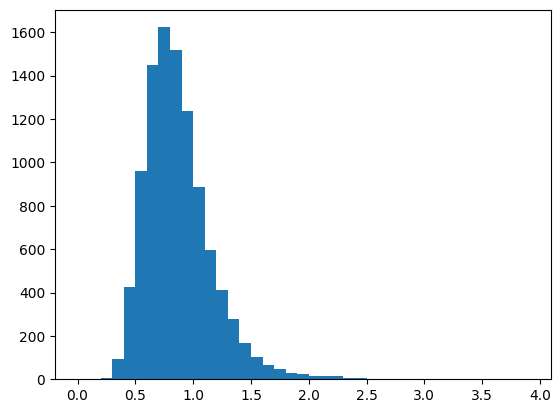

In [ ]:

from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = losses.detach()
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a, bins = np.arange(0,4,0.1))
 
# Show plot
plt.show()

In [ ]:
o = autoencoder1(X_train.detach())
X_emb_train = torch.squeeze(autoencoder1.y).detach()
o = autoencoder1(X_test.detach())
X_emb_test = torch.squeeze(autoencoder1.y).detach()


In [ ]:

# o = autoencoder1(X)
# X_embs = torch.squeeze(autoencoder1.y.detach())
model = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 2000
batch_size = 1000

for epoch in range(n_epochs):
    for i in range(0, len(X_emb_train), batch_size):
        Xbatch = X_emb_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     print(loss)
    # print(f'Finished epoch {epoch}, latest loss {loss}')
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(X_emb_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8339999914169312


In [ ]:
model1 = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
n_epochs = 1000
batch_size = 1000
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model1(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

with torch.no_grad():
    y_pred = model1(X_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.871999979019165
